In [1]:
import string
from collections import Counter
import pandas as pd
import numpy as np
from matplotlib.pylab import plt

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

from cybnews.data import get_data

In [2]:
# 0 = fake
# 1 = real

data = get_data('/home/tober/devel/lewagon/project/cyb-news/data/WELFake_Dataset.csv')

In [3]:
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
print(data.iloc[3])

Unnamed: 0                                                    3
title         Bobby Jindal, raised Hindu, uses story of Chri...
text          A dozen politically active pastors came here f...
label                                                         0
Name: 3, dtype: object


In [120]:
data.info

<bound method DataFrame.info of        Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Ba

In [121]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [122]:
print(data.label.value_counts(normalize=True))
print()
print(data.label.value_counts())

label
1    0.514404
0    0.485596
Name: proportion, dtype: float64

label
1    37106
0    35028
Name: count, dtype: int64


In [123]:
data.isnull().any()

Unnamed: 0    False
title          True
text           True
label         False
dtype: bool

In [124]:
data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [125]:
data = data.fillna('')

In [126]:
data["all_text"] = data["title"] + " " +  data["text"]

In [127]:
data['text_length'] = data['all_text'].apply(len)
data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


In [128]:
data.groupby('label')['text_length'].mean()

label
0    3565.107286
1    3139.031208
Name: text_length, dtype: float64

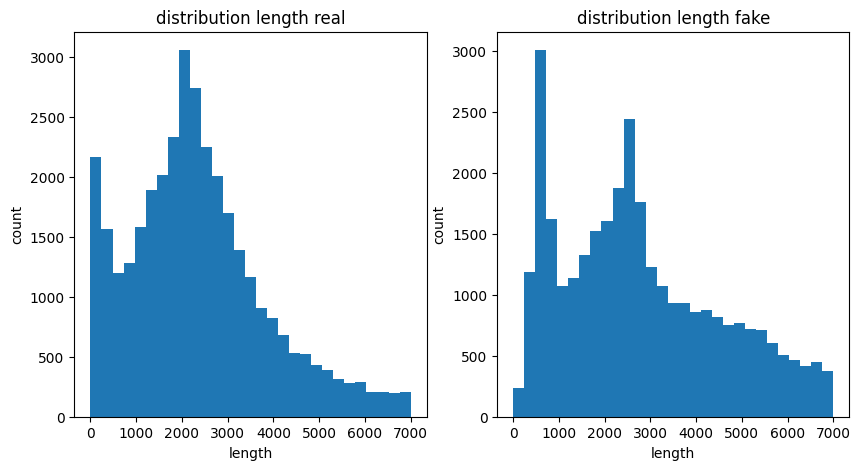

In [129]:
bin = np.linspace(0, 7000, 30)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(data[data["label"]== 1]["text_length"], bins=bin)
ax1.set_title('distribution length real')
ax1.set_xlabel('length')
ax1.set_ylabel('count')

ax2.hist(data[data["label"]== 0]["text_length"], bins=bin)
ax2.set_title('distribution length fake')
ax2.set_xlabel('length')
ax2.set_ylabel('count')
plt.show();


In [130]:
# One could argue to only use data["text"] as X
data["all_text"]
data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


In [131]:
# YOUR CODE HERE

"""def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)
    language = set(stopwords.words("english"))
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)
"""


'def preprocessing(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n\n    for x in "’":\n        sentence = sentence.replace(x, "")\n    #for x in \'""\':\n        #sentence = sentence.replace(x, "")\n\n    tokens = word_tokenize(sentence)\n    language = set(stopwords.words("english"))\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]\n    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]\n    return \' \'.join(n_l)\n'

In [132]:
"""import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter


def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)

    language = set(stopwords.words("english"))
    #language.update()
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)"""

'import string\nfrom nltk.corpus import stopwords\nfrom nltk import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\nfrom collections import Counter\n\n\ndef preprocessing(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n\n    for x in "’":\n        sentence = sentence.replace(x, "")\n    #for x in \'""\':\n        #sentence = sentence.replace(x, "")\n\n    tokens = word_tokenize(sentence)\n\n    language = set(stopwords.words("english"))\n    #language.update()\n    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize(word, pos = "

In [133]:
"""import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

def word_count(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")
    for x in "’":
        sentence = sentence.replace(x, "")
    tokens = word_tokenize(sentence)
    language = set(stopwords.words("english"))
    sentence = [w for  w in tokens if not w in language]
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])

    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    word_counts = Counter(n_l)

    return word_counts

total_word_counts = Counter()
data["all_text_cleaned_test"] = data["all_text"].apply(word_count)
for counts in data["all_text_cleaned_test"]:
    total_word_counts.update(counts)
total = sum(total_word_counts.values())

most_common_words = total_word_counts.most_common(100)
for word, count in most_common_words:
    print(f"{word}: {count}")
"""

'import string\nfrom nltk.corpus import stopwords\nfrom nltk import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\nfrom collections import Counter\n\ndef word_count(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n    for x in "’":\n        sentence = sentence.replace(x, "")\n    tokens = word_tokenize(sentence)\n    language = set(stopwords.words("english"))\n    sentence = [w for  w in tokens if not w in language]\n    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])\n\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]\n    n_l = [WordN

In [134]:
#len(stopwords.words("english"))

#print(stopwords.words("english"))

In [135]:
def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)

    language = set(stopwords.words("english"))
    #language.update(["trump", "clinton", "obama"])
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)

In [136]:
print(data.size)

data_sampled = data.sample(frac=0.1, random_state=42)

print(data_sampled.size)

432804
43278


In [137]:
data_sampled["all_text_cleaned"] = data_sampled["all_text"].apply(preprocessing)

In [138]:
data_preproc = data_sampled[["all_text_cleaned", "label"]]

In [139]:
data_preproc

,all_text_cleaned,label
61370,arnold schwarzenegger send message liberal whi...,1
2189,wow “ mexican need kill donald trump become pr...,1
60609,jimmy carter recover dehydration scare canada ...,0
51565,friar mission revive brooklyn church religious...,0
39431,boy autism make first friend ever mom cant sto...,1
...,...,...
46006,obama condemn trump…says u “ bless muslim comm...,1
33197,czech foreign minister lightly injure car acci...,0
61712,house intel slap subpoena mccain institute ass...,1
17836,terror group plan violence against trump suppo...,1


In [140]:
y = data_preproc["label"]
X = data_preproc["all_text_cleaned"]

In [141]:
X.head()

61370    arnold schwarzenegger send message liberal whi...
2189     wow “ mexican need kill donald trump become pr...
60609    jimmy carter recover dehydration scare canada ...
51565    friar mission revive brooklyn church religious...
39431    boy autism make first friend ever mom cant sto...
Name: all_text_cleaned, dtype: object

In [142]:
#Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [143]:
X_train.shape

(5049,)

In [144]:
pipe = make_pipeline(CountVectorizer(),MultinomialNB())


In [145]:
pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'multinomialnb__force_alpha': T

In [146]:
grid = {
    "countvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
    "multinomialnb__alpha": (0.01, 0.1, 1)
}
search = GridSearchCV(pipe,grid, scoring = "accuracy", cv =5, n_jobs=-1)
search.fit(X_train,y_train)
search.best_score_

/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3

np.float64(0.891663542964802)

In [147]:
search.best_params_


{'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}

In [148]:
y_pred = search.predict(X_test)

In [149]:
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8932532347504621

TF-idf Model


In [150]:
pipe_tf = make_pipeline(TfidfVectorizer(),MultinomialNB())
pipe_tf.get_params()


{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'multinomialnb': MultinomialNB(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocab

In [151]:
grid_tf = {
    "tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
    "multinomialnb__alpha": (0.01, 0.1, 1)
}

search_g = GridSearchCV(pipe_tf,grid_tf, scoring = "accuracy", cv =5, n_jobs=-1)
search_g.fit(X_train,y_train)
search_g.best_score_

/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3

np.float64(0.8857217713842742)

In [152]:
search_g.best_params_
y_pred = search_g.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8923290203327172

In [153]:
"""
M
1.Bag of Words (BoW):
Naive Bayes
SVM
Logistic Regression
Random Forest

2.TF-IDF:
Naive Bayes
SVM
Logistic Regression
Random Forest


Deep
3.Word Embeddings:
SVM
Logistic Regression
Deep Learning (LSTM, CNN)
Transformers (prepare=)

4.Transformers:
Deep Learning (LSTM, CNN)
Transformers models"""

'\nM\n1.Bag of Words (BoW):\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n2.TF-IDF:\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n\nDeep\n3.Word Embeddings:\nSVM\nLogistic Regression\nDeep Learning (LSTM, CNN)\nTransformers (prepare=)\n\n4.Transformers:\nDeep Learning (LSTM, CNN)\nTransformers models'

In [154]:
# Insights:
# Model without Obama, Trump and Clinton drops the score

In [155]:
pipe_svc_tf = make_pipeline(
    TfidfVectorizer(),
    SVC()
)

pipe_svc_tf.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'svc': SVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': None,
 'svc__C': 1.0,
 'svc__break

In [157]:
grid_svc_tf = {
    "tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
    "svc__degree": (1, 3, 5),
    "svc__C": (0.1,1,10, 50),
    "svc__kernel": ("linear", "poly", "rbf", "sigmoid", "precomputed")
}

search_svc = GridSearchCV(
    pipe_svc_tf,
    grid_svc_tf,
    scoring="accuracy",
    cv =2,
    n_jobs=26
)

search_svc.fit(X_train,y_train)
search_svc.best_score_
search_svc.best_params_
y_pred = search_svc.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
192 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tober/.pyenv/versions/3.10.6/envs/cybnews/lib/pyth

0.9477818853974121

Random Forest

In [ ]:
# RandomForestClassifier

pipe_rf_tf = make_pipeline(TfidfVectorizer(),RandomForestClassifier())

pipe_rf_tf.get_params()


{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'randomforestclassifier': RandomForestClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_

In [ ]:
gird_rf_tf = {
    "tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
    "randomforestclassifier__n_estimators": (50, 100, 500, 1000),
    "randomforestclassifier__criterion": ("gini", "entropy", "log_loss")
}

search_rf = GridSearchCV(pipe_rf_tf,gird_rf_tf, scoring = "accuracy", cv =5, n_jobs=-1)
search_rf.fit(X_train,y_train)
search_rf.best_score_

search_rf.best_params_
y_pred = search_rf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy